In [280]:
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns
import scipy.stats

In [2]:
# 환경설정
pd.options.display.float_format = '{:,.1f}'.format
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False

In [67]:
# 데이터 불러오기
사고내역 = pd.read_excel('일반보험요율통계분석_월.xlsx', dtype={'당사지급보험금':float, '당사손해조사비':float})

In [68]:
# 데이터 정보
사고내역.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2127 entries, 0 to 2126
Data columns (total 66 columns):
마감년월               2127 non-null int64
지급구분코드             2127 non-null int64
가상사고접수번호           2127 non-null object
사고목적구분코드           2127 non-null int64
사고목적서열             2127 non-null int64
계약일련번호             2127 non-null int64
소재지일련번호            2127 non-null int64
사고목적담보일련번호         2127 non-null int64
사고목적추산결정일련번호       2127 non-null int64
상품코드               2127 non-null int64
보험약관코드             2127 non-null int64
요율구분코드             2127 non-null int64
가상증권번호             2127 non-null object
계약변경일련번호           2127 non-null int64
계약소재지일련번호          2127 non-null int64
계약목적물일련번호          2127 non-null int64
섹션코드               2127 non-null int64
담보특약코드             2127 non-null int64
계약매핑여부             2127 non-null int64
공동인수구분코드           2127 non-null int64
주관보험사코드            2127 non-null object
당사인수율              2127 non-null float64
원계약청약일자            2127 non-nu

In [555]:
# 전처리(1)
사고내역_가공 = 사고내역.copy()
사고내역_가공['사고발생일자'] = 사고내역_가공['사고발생일자'].astype(str).apply(parse)
사고내역_가공['사고접수일자'] = 사고내역_가공['사고접수일자'].astype(str).apply(parse)
사고내역_가공['보험기간시작일자'] = 사고내역_가공['보험기간시작일자'].astype(str).apply(parse)
사고내역_가공['보험기간종료일자'] = 사고내역_가공['보험기간종료일자'].astype(str).apply(parse)
사고내역_가공['최초추산일자'] = 사고내역_가공['최초추산일자'].astype(str).apply(parse)
사고내역_가공['확정일자'] = 사고내역_가공['확정일자'].astype(str).apply(parse)
사고내역_가공['증권번호'] = 사고내역_가공['가상증권번호']
사고내역_가공['사고접수번호'] = 사고내역_가공['가상사고접수번호']
사고내역_가공 = 사고내역_가공[['사고접수번호', '증권번호', '사고발생일자', '사고접수일자', '보험기간시작일자', '보험기간종료일자', '최초추산일자', '확정일자', '당사지급보험금', '당사후기추산보험금', '당사손해조사비']]

# 전처리(2)
사고내역_그룹 = 사고내역_가공.pivot_table(index=['사고접수번호', '증권번호', '사고발생일자', '사고접수일자', '보험기간시작일자', '보험기간종료일자', '최초추산일자'],
                            values=['확정일자', '당사지급보험금', '당사손해조사비'],
                            aggfunc={'당사지급보험금':np.sum, '당사손해조사비':np.sum, '확정일자':np.max},
                            fill_value=0).reset_index()
사고내역_그룹['사고발생년도'] = 사고내역_그룹['사고발생일자'].apply(lambda x:x.year)
사고내역_그룹['인수년도'] = 사고내역_그룹['보험기간시작일자'].apply(lambda x:x.year)
사고내역_그룹['보장기간'] = (사고내역_그룹['보험기간종료일자'] - 사고내역_그룹['보험기간시작일자']).apply(lambda x:x.days)
사고내역_그룹['사고발생시점'] = (사고내역_그룹['사고발생일자'] - 사고내역_그룹['보험기간시작일자']).apply(lambda x:x.days)
사고내역_그룹['보고지연'] = (사고내역_그룹['사고접수일자'] - 사고내역_그룹['사고발생일자']).apply(lambda x:x.days)
사고내역_그룹['추산지연'] = (사고내역_그룹['최초추산일자'] - 사고내역_그룹['사고접수일자']).apply(lambda x:x.days)
사고내역_그룹['확정지연'] = (사고내역_그룹['확정일자'] - 사고내역_그룹['최초추산일자']).apply(lambda x:x.days)

# 전처리(3)
사고내역_유효 = 사고내역_그룹.query('당사지급보험금 > 0').reset_index(drop=True)
사고내역_유효['당사지급보험금'] = 사고내역_유효['당사지급보험금'].astype(float)
사고내역_유효['사고발생시점_비중'] = 사고내역_유효['사고발생시점']/사고내역_유효['보장기간']*100
사고내역_유효['당사손해조사비_비중'] = 사고내역_유효['당사손해조사비']/사고내역_유효['당사지급보험금']*100
사고내역_유효.head()

,사고접수번호,증권번호,사고발생일자,사고접수일자,보험기간시작일자,보험기간종료일자,최초추산일자,당사손해조사비,당사지급보험금,확정일자,사고발생년도,인수년도,보장기간,사고발생시점,보고지연,추산지연,확정지연,사고발생시점_비중,당사손해조사비_비중
0,C101971330,P387915556135958,2011-07-02,2011-07-04,2011-06-27,2012-06-27,2011-07-21,"436,000.0","2,620,000.0",2011-08-29,2011,2011,366,5,2,17,39,1.4,16.6
1,C10435689,P279619257607058,2008-03-13,2008-03-20,2007-09-28,2008-09-28,2008-03-20,0.0,"47,116,746.0",2010-05-10,2008,2007,366,167,7,0,781,45.6,0.0
2,C104806985,P202795263275279,2012-08-30,2012-09-05,2011-09-21,2012-09-21,2012-09-05,"2,809,000.0","42,110,792.0",2012-12-27,2012,2011,366,344,6,0,113,94.0,6.7
3,C105712104,P341509396775539,2012-02-07,2012-02-08,2011-07-14,2012-07-14,2012-02-17,"1,646,000.0","36,281,807.0",2012-06-29,2012,2011,366,208,1,9,133,56.8,4.5
4,C106325047,P2145437044607,2014-05-22,2014-06-25,2013-09-18,2014-09-18,2014-06-25,"1,086,300.0","26,090,000.0",2014-08-27,2014,2013,365,246,34,0,63,67.4,4.2


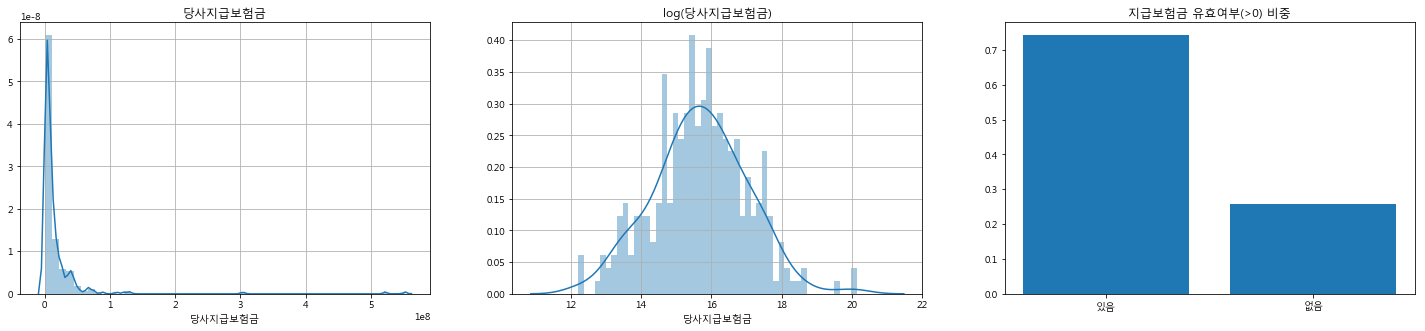

In [556]:
# 지급보험금 분포
plt.figure(figsize=(25,5))

plt.subplot(1, 3, 1)
sns.distplot(사고내역_유효['당사지급보험금'], bins=50)
plt.title('당사지급보험금')
plt.grid()

plt.subplot(1, 3, 2)
sns.distplot(np.log(사고내역_유효['당사지급보험금']), bins=50)
plt.title('log(당사지급보험금)')
plt.grid()

plt.subplot(1, 3, 3)
지급보험금유효여부 = ['있음', '없음']
지급보험금유효비중 = [len(사고내역_그룹.query('당사지급보험금 > 0'))/len(사고내역_그룹), len(사고내역_그룹.query('당사지급보험금 == 0'))/len(사고내역_그룹)]
plt.bar(지급보험금유효여부, 지급보험금유효비중)
plt.title('지급보험금 유효여부(>0) 비중')

plt.show()

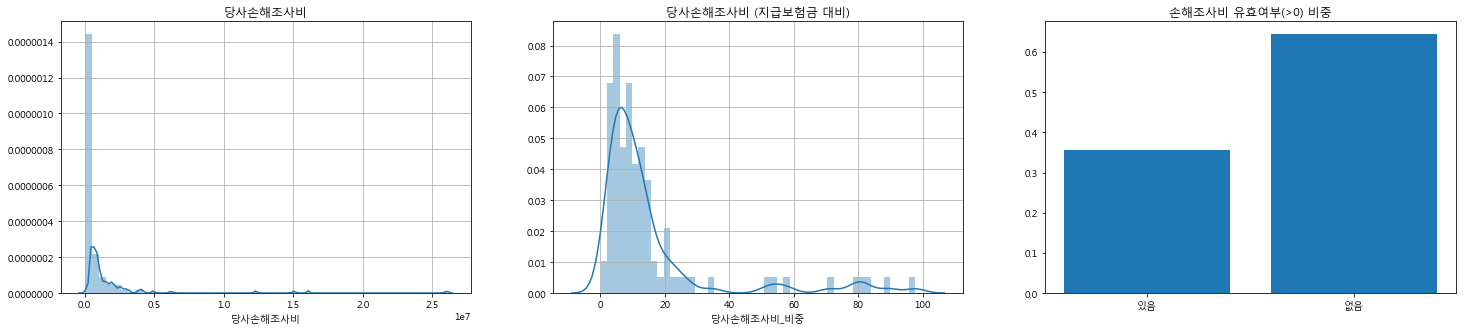

In [557]:
# 손해조사비 분포
plt.figure(figsize=(25,5))

plt.subplot(1, 3, 1)
sns.distplot(사고내역_유효['당사손해조사비'], bins=50)
plt.title('당사손해조사비')
plt.grid()

plt.subplot(1, 3, 2)
sns.distplot(사고내역_유효.query('당사손해조사비 > 0')['당사손해조사비_비중'], bins=50)
plt.title('당사손해조사비 (지급보험금 대비)')
plt.grid()

plt.subplot(1, 3, 3)
손해조사비유효여부 = ['있음', '없음']
손해조사비유효비중 = [len(사고내역_그룹.query('당사손해조사비 > 0'))/len(사고내역_그룹), len(사고내역_그룹.query('당사손해조사비 == 0'))/len(사고내역_그룹)]
plt.bar(손해조사비유효여부, 손해조사비유효비중)
plt.title('손해조사비 유효여부(>0) 비중')

plt.show()

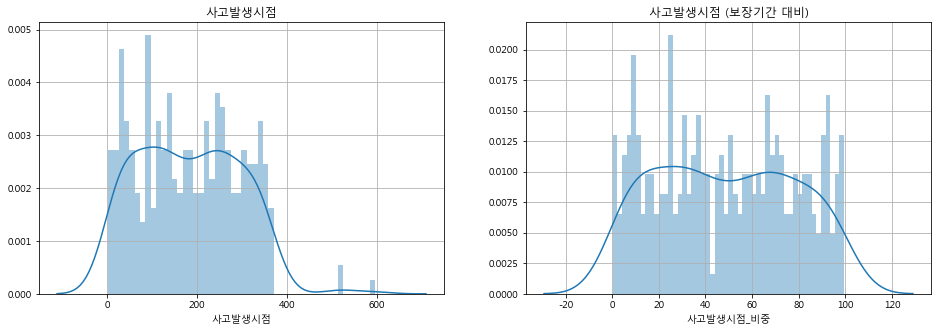

In [558]:
# 사고발생시점 분포
plt.figure(figsize=(16,5))

plt.subplot(1, 2, 1)
sns.distplot(사고내역_유효['사고발생시점'], bins=50)
plt.title('사고발생시점')
plt.grid()

plt.subplot(1, 2, 2)
sns.distplot(사고내역_유효['사고발생시점_비중'], bins=50)
plt.title('사고발생시점 (보장기간 대비)')
plt.grid()

plt.show()

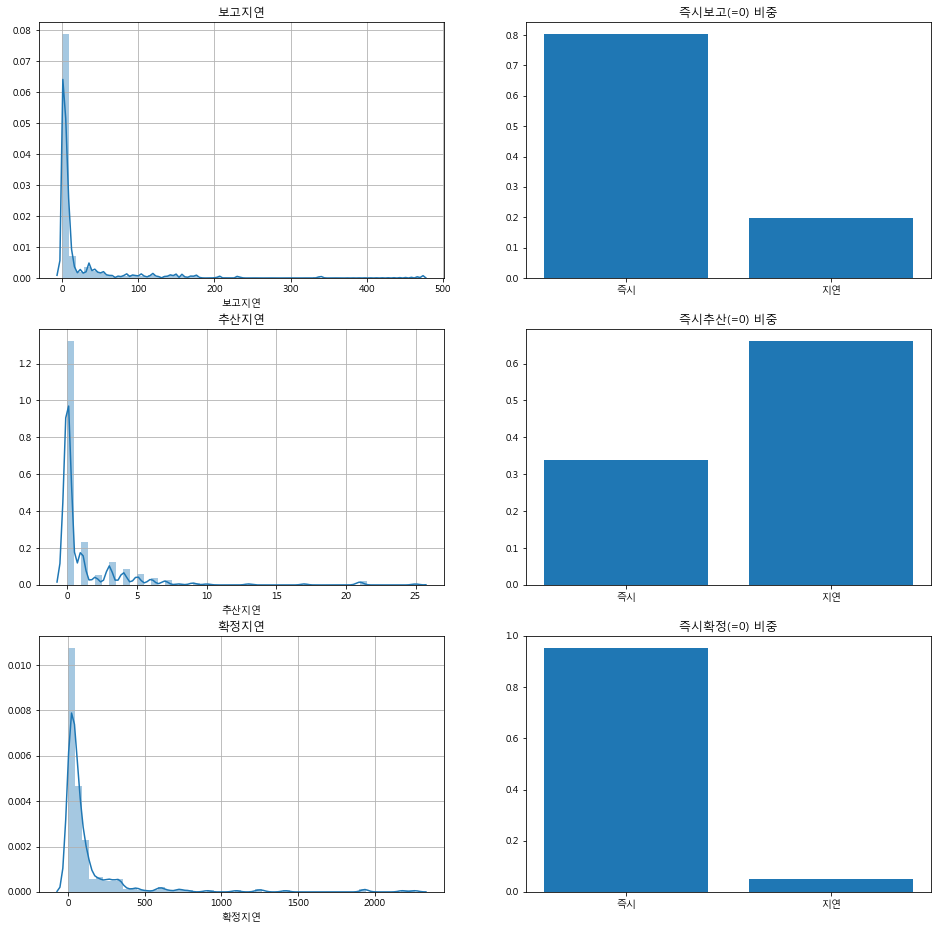

In [559]:
# 보고지연, 추산지연, 확정지연 분포
plt.figure(figsize=(16,16))

plt.subplot(3, 2, 1)
sns.distplot(사고내역_유효['보고지연'], bins=50)
plt.title('보고지연')
plt.grid()

plt.subplot(3, 2, 2)
즉시보고여부 = ['즉시', '지연']
즉시보고비중 = [len(사고내역_유효.query('보고지연 > 0'))/len(사고내역_유효), len(사고내역_유효.query('보고지연 == 0'))/len(사고내역_유효)]
plt.bar(즉시보고여부, 즉시보고비중)
plt.title('즉시보고(=0) 비중')

plt.subplot(3, 2, 3)
sns.distplot(사고내역_유효['추산지연'], bins=50)
plt.title('추산지연')
plt.grid()

plt.subplot(3, 2, 4)
즉시추산여부 = ['즉시', '지연']
즉시추산비중 = [len(사고내역_유효.query('추산지연 > 0'))/len(사고내역_유효), len(사고내역_유효.query('추산지연 == 0'))/len(사고내역_유효)]
plt.bar(즉시추산여부, 즉시추산비중)
plt.title('즉시추산(=0) 비중')

plt.subplot(3, 2, 5)
sns.distplot(사고내역_유효['확정지연'], bins=50)
plt.title('확정지연')
plt.grid()

plt.subplot(3, 2, 6)
즉시확정여부 = ['즉시', '지연']
즉시확정비중 = [len(사고내역_유효.query('확정지연 > 0'))/len(사고내역_유효), len(사고내역_유효.query('확정지연 == 0'))/len(사고내역_유효)]
plt.bar(즉시확정여부, 즉시확정비중)
plt.title('즉시확정(=0) 비중')

plt.show()

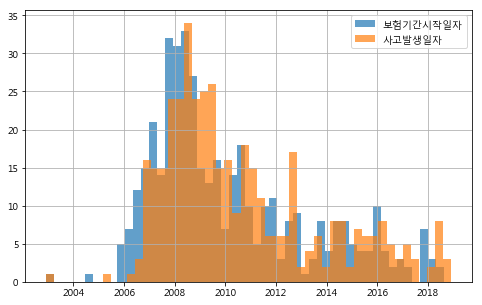

In [560]:
# 보험기간시작일자, 사고발생일자 비교
plt.figure(figsize=(8, 5))

plt.hist(사고내역_그룹['보험기간시작일자'], bins=50, alpha=0.7, label='보험기간시작일자')
plt.hist(사고내역_그룹['사고발생일자'], bins=50, alpha=0.7, label='사고발생일자')
plt.grid()
plt.legend()

plt.show()

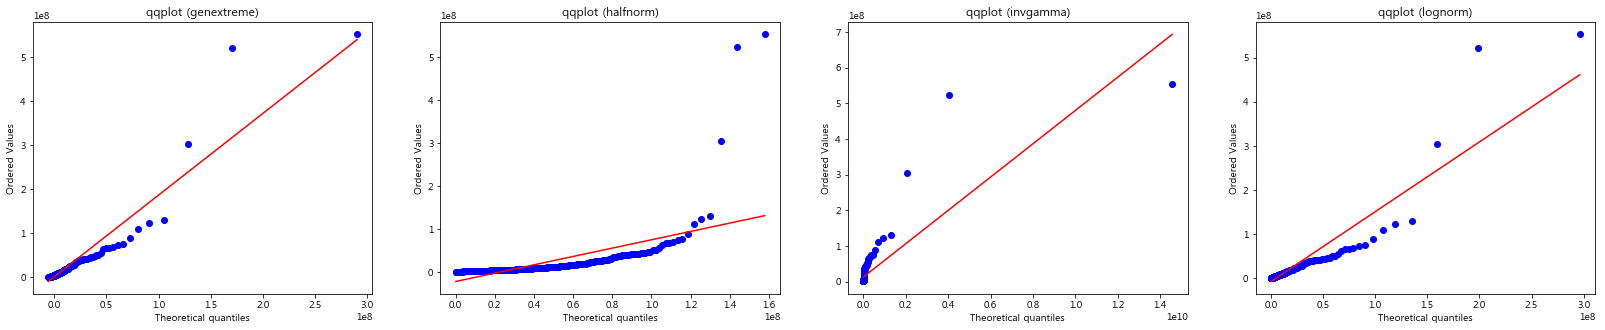

In [561]:
# 지급보험금 분포 추정
"""
분포목록 = ['alpha', 'anglit', 'arcsine', 'beta', 'betaprime',
           'bradford', 'burr', 'cauchy', 'chi', 'chi2', 'cosine', 'dgamma',
           'dweibull', 'erlang', 'expon', 'exponweib', 'exponpow', 'f', 'fatiguelife',
           'fisk', 'foldcauchy', 'foldnorm', 'frechet_r', 'frechet_l', 'genlogistic',
           'genpareto', 'genexpon', 'genextreme', 'gausshyper','gamma', 'gengamma',
           'genhalflogistic', 'gilbrat', 'gompertz', 'gumbel_r', 'gumbel_l', 'halfcauchy',
           'halflogistic', 'halfnorm', 'hypsecant', 'invgamma', 'invgauss', 'invweibull',
           'johnsonsb', 'johnsonsu', 'ksone', 'kstwobign', 'laplace', 'logistic', 'loggamma',
           'loglaplace', 'lognorm', 'lomax', 'maxwell', 'mielke', 'nakagami', 'ncx2', 'ncf',
           'nct', 'norm', 'pareto', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rdist',
           'reciprocal', 'rayleigh', 'rice', 'recipinvgauss', 'semicircular', 't', 'triang',
           'truncexpon', 'truncnorm', 'tukeylambda', 'uniform', 'vonmises', 'wald', 'weibull_min',
           'weibull_max', 'wrapcauchy']
"""

# 분포선택 : invgamma
데이터 = 사고내역_유효['당사지급보험금']
분포목록 = ['genextreme', 'halfnorm', 'invgamma', 'lognorm']
n = len(분포목록)
fig, ax = plt.subplots(1, n, figsize=(7*n, 5))
for i in range(len(분포목록)):
    분포 = getattr(scipy.stats, 분포목록[i])
    모수 = 분포.fit(데이터, floc=0)
    결과 = scipy.stats.probplot(데이터, dist=분포, sparams=(*모수[:-2], 모수[-2], 모수[-1]), plot=ax[i])
    ax[i].set_title('qqplot ({})'.format(분포목록[i]))

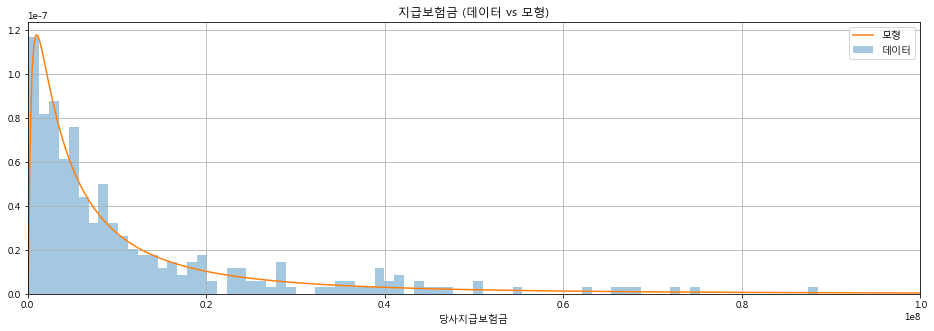

In [595]:
# 지급보험금 분포
plt.figure(figsize=(16,5))

데이터 = 사고내역_유효['당사지급보험금']
sns.distplot(데이터, bins=500, kde=False, norm_hist=True, label='데이터')

선택분포 = scipy.stats.lognorm
모수 = 선택분포.fit(데이터)
모델_지급보험금 = 선택분포(*모수[:-2], loc=모수[-2], scale=모수[-1])
범위 = np.linspace(모델_지급보험금.ppf(0.000), 모델_지급보험금.ppf(0.995), 1000)
밀도 = 모델_지급보험금.pdf(범위)
plt.plot(범위, 밀도, label='모형')

plt.title('지급보험금 (데이터 vs 모형)')
plt.grid()
plt.xlim(0, 1e8)
plt.legend()
plt.show()

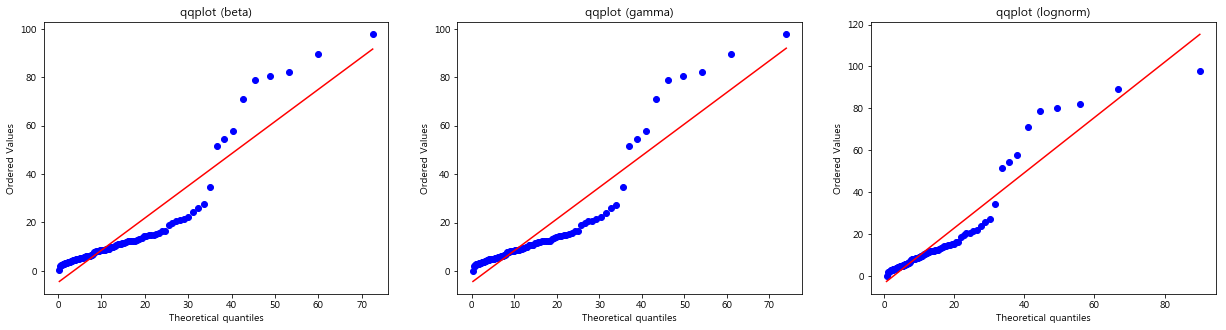

In [563]:
# 손해조사비 비중 추정
"""
분포목록 = ['alpha', 'anglit', 'arcsine', 'beta', 'betaprime',
           'bradford', 'burr', 'cauchy', 'chi', 'chi2', 'cosine', 'dgamma',
           'dweibull', 'erlang', 'expon', 'exponweib', 'exponpow', 'f', 'fatiguelife',
           'fisk', 'foldcauchy', 'foldnorm', 'frechet_r', 'frechet_l', 'genlogistic',
           'genpareto', 'genexpon', 'genextreme', 'gausshyper','gamma', 'gengamma',
           'genhalflogistic', 'gilbrat', 'gompertz', 'gumbel_r', 'gumbel_l', 'halfcauchy',
           'halflogistic', 'halfnorm', 'hypsecant', 'invgamma', 'invgauss', 'invweibull',
           'johnsonsb', 'johnsonsu', 'ksone', 'kstwobign', 'laplace', 'logistic', 'loggamma',
           'loglaplace', 'lognorm', 'lomax', 'maxwell', 'mielke', 'nakagami', 'ncx2', 'ncf',
           'nct', 'norm', 'pareto', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rdist',
           'reciprocal', 'rayleigh', 'rice', 'recipinvgauss', 'semicircular', 't', 'triang',
           'truncexpon', 'truncnorm', 'tukeylambda', 'uniform', 'vonmises', 'wald', 'weibull_min',
           'weibull_max', 'wrapcauchy']
"""

# 분포선택 : invgamma
데이터 = 사고내역_유효.query('당사손해조사비 > 0')['당사손해조사비_비중']
분포목록 = ['beta', 'gamma', 'lognorm']
n = len(분포목록)
fig, ax = plt.subplots(1, n, figsize=(7*n, 5))
for i in range(len(분포목록)):
    분포 = getattr(scipy.stats, 분포목록[i])
    모수 = 분포.fit(데이터, loc=0, scale=100)
    결과 = scipy.stats.probplot(데이터, dist=분포, sparams=(*모수[:-2], 모수[-2], 모수[-1]), plot=ax[i])
    ax[i].set_title('qqplot ({})'.format(분포목록[i]))

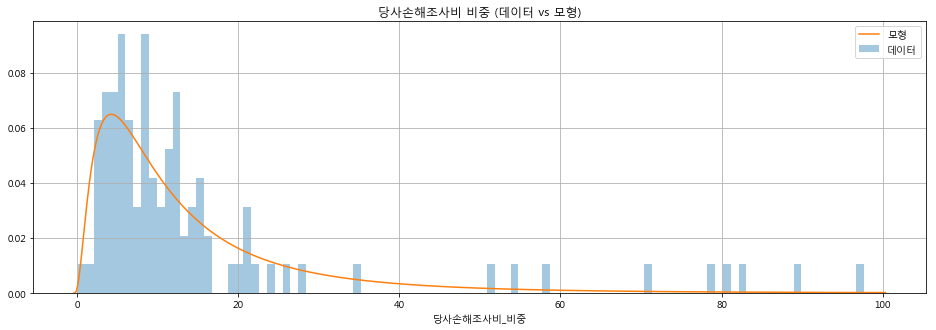

In [594]:
# 손해조사비 비중 분포
plt.figure(figsize=(16,5))

데이터 = 사고내역_유효.query('당사손해조사비 > 0')['당사손해조사비_비중']
sns.distplot(데이터, bins=100, kde=False, norm_hist=True, label='데이터')

선택분포 = scipy.stats.lognorm
모수 = 선택분포.fit(데이터, loc=0, scale=100)
모델_손해조사비 = 선택분포(*모수[:-2], loc=모수[-2], scale=모수[-1])
범위 = np.linspace(모델_손해조사비.ppf(0.000), 모델_손해조사비.ppf(0.995), 1000)
밀도 = 모델_손해조사비.pdf(범위)
plt.plot(범위, 밀도, label='모형')

plt.title('당사손해조사비 비중 (데이터 vs 모형)')
plt.grid()
plt.legend()
plt.show()

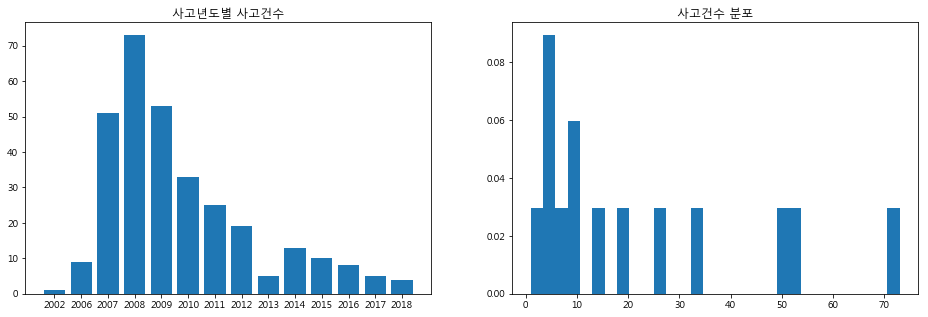

In [631]:
# 사고건수
plt.figure(figsize=(16,5))

plt.subplot(1, 2, 1)
사고건수 = 사고내역_유효.groupby('사고발생년도')['사고발생년도'].count()
plt.bar(사고건수.index.astype(str), 사고건수.values)
plt.title('사고년도별 사고건수')

plt.subplot(1, 2, 2)
plt.hist(사고건수, bins=30, density=True)
plt.title('사고건수 분포')

plt.show()

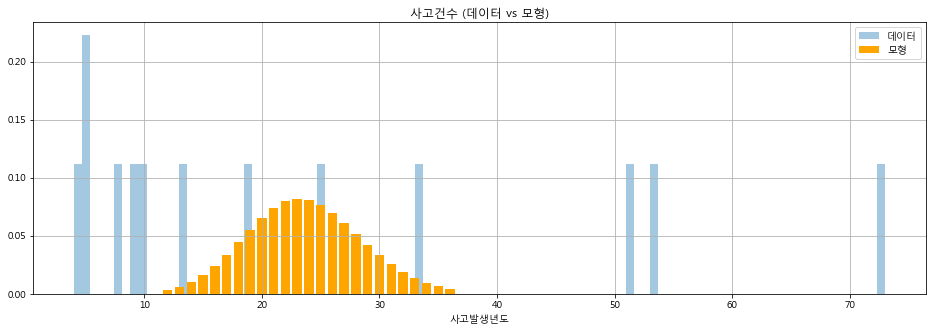

In [801]:
# 사고건수 분포 추정
plt.figure(figsize=(16,5))

데이터 = 사고건수[사고건수.index != 2002]
sns.distplot(데이터, bins=100, kde=False, norm_hist=True, label='데이터')

선택분포 = scipy.stats.poisson
모수 = 데이터.mean()
모델_사고건수 = 선택분포(mu=모수)
범위 = np.arange(모델_사고건수.ppf(0.005), 모델_사고건수.ppf(0.995))
확률 = 모델_사고건수.pmf(범위)
plt.bar(범위, 확률, label='모형', color='orange')

plt.title('사고건수 (데이터 vs 모형)')
plt.grid()
plt.legend()
plt.show()

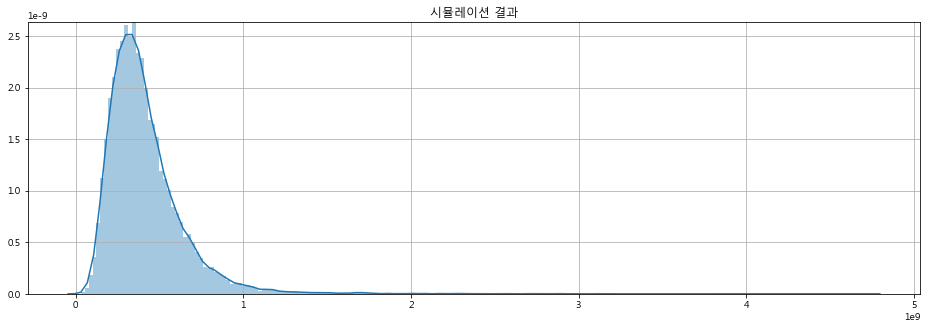

In [743]:
# 시뮬레이션
plt.figure(figsize=(16,5))

시뮬레이션_횟수 = 20000
시뮬레이션_사고건수 = 모델_사고건수.rvs(시뮬레이션_횟수)

시뮬레이션_결과 = []
for i in range(len(시뮬레이션_사고건수)):
    시뮬레이션_지급보험금 = 모델_지급보험금.rvs(시뮬레이션_사고건수[i])
    시뮬레이션_사고조사비 = 모델_손해조사비.rvs(시뮬레이션_사고건수[i])/100
    시뮬레이션_발생손해액 = (시뮬레이션_지급보험금*(1+시뮬레이션_사고조사비)).sum()
    시뮬레이션_결과.append(시뮬레이션_발생손해액)
    
시뮬레이션_결과 = np.array(시뮬레이션_결과)

sns.distplot(시뮬레이션_결과, bins=200)
plt.title('시뮬레이션 결과')
plt.grid()
plt.show()

In [803]:
# 시뮬레이션 결과
mu, sigma, value_at_risk = 시뮬레이션_결과.mean(), 시뮬레이션_결과.std(), np.percentile(시뮬레이션_결과, 99.5)
print('-------- 손해액(1년) 시뮬레이션 결과 --------')
print('1. 평균 : {:,.0f}원'.format(mu))
print('2. 표준편차 : {:,.0f}원'.format(sigma))
print('3. Value-at-Risk (99.5%) : {:,.0f}원'.format(value_at_risk))
print('-------------------------------------------')

-------- 손해액(1년) 시뮬레이션 결과 --------
1. 평균 : 413,615,218원
2. 표준편차 : 225,771,860원
3. Value-at-Risk (99.5%) : 1,422,856,761원
-------------------------------------------
